# Modeling

In [1]:
import pandas as pd
from datetime import timedelta

#### Import data

In [2]:
pwd

'C:\\Users\\jerem\\Desktop\\nonsense\\flagship'

In [3]:
toy_dataset_df = pd.read_csv('toy_dataset_1_10_23.csv')
toy_products_df = pd.read_csv('toy_products_1_10_23.csv')

In [4]:
toy_products_df.shape

(3125, 6)

In [5]:
toy_dataset_df.shape

(32151, 23)

In [6]:
toy_dataset_df['timestamp'] = pd.to_datetime(toy_dataset_df['timestamp'])

#### Create train, test data sets based on date split

In [7]:
split_date = '2022-04-01' # choose a date to split the data - roughly 80/20 split
train = toy_dataset_df[toy_dataset_df['timestamp'] < split_date]
test = toy_dataset_df[toy_dataset_df['timestamp'] >= split_date]

In [18]:
test_dates = test['timestamp'].dt.date.unique().tolist()
len(test_dates)

230

In [8]:
# percent of data in training data set
round(train.shape[0] / toy_dataset_df.shape[0] * 100.0,2)

81.64

In [11]:
print(train.shape)
print(test.shape)

(26248, 23)
(5903, 23)


### Baseline Model - top 10 titles over previous week

In [14]:
def get_top10_title_preds(as_of_dt, prev_days=7, top_n=10):
    """
    Function to return the top 10 most popular product_titles sold in previous n days from as_of date
    Returns a pandas dataframe of 10 records
    """
    given_date = pd.to_datetime(as_of_dt)
    start_date = given_date - timedelta(days=prev_days)
    last_week_df = toy_dataset_df[(toy_dataset_df['timestamp']<given_date) & (toy_dataset_df['timestamp']>start_date)]
    top10_last_wk_df = last_week_df.groupby('product_title').size().reset_index(name='count').sort_values('count', ascending=False).head(top_n)
    top10_last_wk_df['transaction_date'] = as_of_dt
    top10_last_wk_df['title_rank'] = top10_last_wk_df['count'].rank(method='first', ascending=False)
    top10_last_wk_df.columns = ['title_pred', 'prev_wk_cnt', 'transaction_date', 'title_rank']
    return top10_last_wk_df

In [16]:
get_top10_title_preds(as_of_dt='2021-08-13')

,title_pred,prev_wk_cnt,transaction_date,title_rank
4,Olympic Running,77,2021-08-13,1.0
2,Iron Running,36,2021-08-13,2.0
9,Vanguard Sandal,16,2021-08-13,3.0
0,Classic Sneaker,11,2021-08-13,4.0
3,League Running,10,2021-08-13,5.0
1,Hustler Boot,9,2021-08-13,6.0
6,Rogue Sneaker,8,2021-08-13,7.0
7,Scalar Sandal,5,2021-08-13,8.0
8,Stacked Hiking Boot,2,2021-08-13,9.0
5,Original Boot,1,2021-08-13,10.0


In [19]:
# Loop over test dates, create preds, join preds back to transactions to create eval_df

full_eval_df = pd.DataFrame()

for index, test_dt in enumerate(test_dates):
    print(index, end=',')
    
    pred_df = get_top10_title_preds(as_of_dt=test_dt)
    
    # Join the recommended item predictions to the test data set on the transaction date
    join_df = pd.merge(left=test[test['timestamp'].dt.date==test_dt], 
                       right=pred_df[['title_pred','title_rank']], 
                       left_on='product_title',
                       right_on='title_pred',
                       how='left')
    
    full_eval_df = pd.concat([full_eval_df, join_df])

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,

In [22]:
assert full_eval_df.shape[0] == test.shape[0]

In [23]:
full_eval_df.head()

,Unnamed: 0,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,product_size,...,zip_med_age,zip_male_female_ratio,zip_tot_pop,zip_tot_white_nh,zip_med_hh_income,zip_mean_hh_income,zip_pct_emp_lf,zip_unemp_rate,title_pred,title_rank
0,58,2022-05-22 14:00:00,701140827973030343,901098790880827689,71.0,Olympic Running,Han Purple,Kids,Running,12.5,...,47.2,87.2,30908.0,23172.0,163016.0,268666.0,65.9,2.3,Olympic Running,1.0
1,2955,2022-05-22 08:00:00,5009790446010554491,6458481418216291208,224.0,Olympic Running,Vermilion (Plochere),Men,Running,9.0,...,28.4,98.8,75068.0,21235.0,55269.0,71979.0,62.6,7.0,Olympic Running,1.0
2,4413,2022-05-22 09:00:00,9583150991463340343,529781945332660367,275.0,Iron Running,Prussian Blue,Men,Running,14.5,...,38.4,91.0,44041.0,33057.0,85768.0,111260.0,66.1,4.1,Iron Running,3.0
3,4414,2022-05-22 09:00:00,9583150991463340343,529781945332660367,275.0,Iron Running,Pastel Magenta,Women,Running,8.5,...,38.4,91.0,44041.0,33057.0,85768.0,111260.0,66.1,4.1,Iron Running,3.0
4,9795,2022-05-22 16:00:00,12894699444984033920,9918956172069791431,224.0,Olympic Running,Prussian Blue,Women,Running,9.0,...,49.4,90.5,12592.0,9817.0,197000.0,329223.0,59.8,4.4,Olympic Running,1.0


In [24]:
# Percent of test purchases that were in top 10
full_eval_df['title_rank'].count() / full_eval_df.shape[0]

0.9552769778078943

In [27]:
# average rec rank of purchases that fell in top 10
full_eval_df['title_rank'].mean()

3.7389608086540167

<AxesSubplot:>

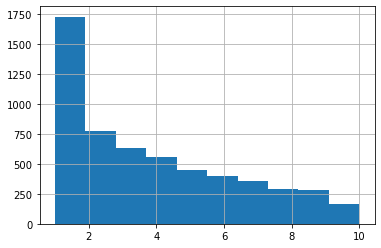

In [28]:
full_eval_df['title_rank'].hist()

### Baseline model - top 10 title-gender products over previous week

In [39]:
def get_top10_title_gender_preds(as_of_dt, prev_days=7, top_n=10):
    """
    Function to return the top 10 most popular title-gender products sold in previous n days from as_of date
    Returns a pandas dataframe of 10 records
    """
    given_date = pd.to_datetime(as_of_dt)
    start_date = given_date - timedelta(days=prev_days)
    last_week_df = toy_dataset_df[(toy_dataset_df['timestamp']<given_date) & 
                                  (toy_dataset_df['timestamp']>start_date)]
    top10_last_wk_df = last_week_df.groupby(['product_title', 'product_gender']).size().reset_index(name='count').sort_values('count', ascending=False).head(top_n)
    top10_last_wk_df['title_rank'] = top10_last_wk_df['count'].rank(method='first', ascending=False)
    top10_last_wk_df.columns = ['title_pred', 'gender_pred', 'prev_wk_cnt', 'pred_rank']
    top10_last_wk_df['transaction_date'] = as_of_dt
    return top10_last_wk_df

In [40]:
get_top10_title_gender_preds(as_of_dt = '2022-08-13', prev_days=7, top_n=10)

,title_pred,gender_pred,prev_wk_cnt,pred_rank,transaction_date
13,Olympic Running,Women,29,1.0,2022-08-13
8,League Running,Women,19,2.0,2022-08-13
0,Bejeweled Boot,Unisex,17,3.0,2022-08-13
6,Iron Running,Women,16,4.0,2022-08-13
4,Hustler Boot,Women,16,5.0,2022-08-13
14,Olympic Running,Youth,11,6.0,2022-08-13
5,Iron Running,Men,10,7.0,2022-08-13
10,Marathon Running,Women,10,8.0,2022-08-13
17,Rogue Sneaker,Women,9,9.0,2022-08-13
11,Olympic Running,Kids,8,10.0,2022-08-13


In [42]:
# Loop over test dates, create preds, join preds back to transactions to create eval_df

full_eval_df = pd.DataFrame()

for index, test_dt in enumerate(test_dates):
    print(index, end=',')
    
    pred_df = get_top10_title_gender_preds(as_of_dt=test_dt)
    
    # Join the recommended item predictions to the test data set on the transaction date
    join_df = pd.merge(left=test[test['timestamp'].dt.date==test_dt], 
                       right=pred_df[['title_pred', 'gender_pred', 'pred_rank']], 
                       left_on=['product_title','product_gender'],
                       right_on=['title_pred', 'gender_pred'],
                       how='left')
    
    full_eval_df = pd.concat([full_eval_df, join_df])

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,

In [43]:
assert full_eval_df.shape[0] == test.shape[0]

In [44]:
# Percent of test purchases that were in top 10
full_eval_df['pred_rank'].count() / full_eval_df.shape[0]

0.6408605793664238

In [45]:
# average rec rank of purchases that fell in top 10
full_eval_df['pred_rank'].mean()

4.274649748876553

<AxesSubplot:>

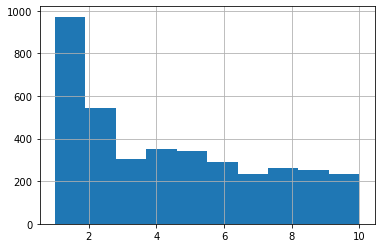

In [46]:
full_eval_df['pred_rank'].hist()

In [47]:
full_eval_df.head()

,Unnamed: 0,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,product_size,...,zip_male_female_ratio,zip_tot_pop,zip_tot_white_nh,zip_med_hh_income,zip_mean_hh_income,zip_pct_emp_lf,zip_unemp_rate,title_pred,gender_pred,pred_rank
0,58,2022-05-22 14:00:00,701140827973030343,901098790880827689,71.0,Olympic Running,Han Purple,Kids,Running,12.5,...,87.2,30908.0,23172.0,163016.0,268666.0,65.9,2.3,NaN,NaN,NaN
1,2955,2022-05-22 08:00:00,5009790446010554491,6458481418216291208,224.0,Olympic Running,Vermilion (Plochere),Men,Running,9.0,...,98.8,75068.0,21235.0,55269.0,71979.0,62.6,7.0,NaN,NaN,NaN
2,4413,2022-05-22 09:00:00,9583150991463340343,529781945332660367,275.0,Iron Running,Prussian Blue,Men,Running,14.5,...,91.0,44041.0,33057.0,85768.0,111260.0,66.1,4.1,Iron Running,Men,8.0
3,4414,2022-05-22 09:00:00,9583150991463340343,529781945332660367,275.0,Iron Running,Pastel Magenta,Women,Running,8.5,...,91.0,44041.0,33057.0,85768.0,111260.0,66.1,4.1,Iron Running,Women,3.0
4,9795,2022-05-22 16:00:00,12894699444984033920,9918956172069791431,224.0,Olympic Running,Prussian Blue,Women,Running,9.0,...,90.5,12592.0,9817.0,197000.0,329223.0,59.8,4.4,Olympic Running,Women,1.0


In [48]:
# create title-gender field
toy_dataset_df['product_title_gender'] = toy_dataset_df['product_title'] + '-' + toy_dataset_df['product_gender']

### Collaborative Filtering